# Data


In [1]:
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset

In [2]:
num_images_per_label = 6000  
dataset_name = 'FashionMNIST' # 'MNIST' or 'CIFAR10'

In [3]:
if dataset_name == 'MNIST':
    dataset = MNIST(root='./../data', train=True, download=True, transform=ToTensor())
elif dataset_name == 'CIFAR10':
    dataset = CIFAR10(root='./../data', train=True, download=True, transform=ToTensor())
elif dataset_name == 'FashionMNIST':
    dataset = FashionMNIST(root='./../data', train=True, download=True, transform=ToTensor())
else:
    raise ValueError("Unsupported dataset. Please choose 'MNIST' or 'CIFAR10'.")

import random 
# Custom dataset to filter 1000 samples per label
class FilteredDatasetOneLabel(TensorDataset):
    def __init__(self, dataset, num_images_per_label, data_label):
        self.dataset = dataset
        self.num_images_per_label = num_images_per_label
        self.filtered_data = []
        self.label = data_label
        if self.label == None:
            label = random.randint(0, 9)  # Randomly select a label from 0 to 9
        self._filter_dataset()

    def _filter_dataset(self):
        image_count = 0
        for image, label in self.dataset:
            if label == self.label and image_count < self.num_images_per_label:
                self.filtered_data.append((image, label))
            if image_count >= self.num_images_per_label:
                break
            image_count += 1
        print(f"Filtered {len(self.filtered_data)} images for label {self.label}.")

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, index):
        return self.filtered_data[index]

Filtered 560 images for label 0.


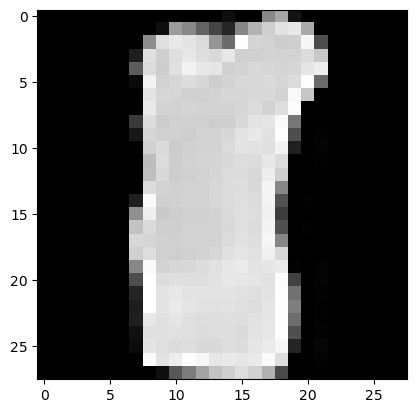

In [4]:
# Create the filtered dataset
filtered_dataset = FilteredDatasetOneLabel(dataset, num_images_per_label, data_label=0)
dataloader = DataLoader(filtered_dataset, batch_size=256, shuffle=True)

# Visualize the dataset
import matplotlib.pyplot as plt

def visualize_dataset(dataloader, label_show=True):
    # Visualize one image from each class
    classes = dataloader.dataset.dataset.classes
    images, labels = [], []
    for image, label in dataloader:
        images.append(image[0])
            

    plt.imshow(images[0].squeeze(), cmap='gray')
        
    
visualize_dataset(dataloader)

In [6]:
# image shape 
print(f"Image shape: {filtered_dataset[0][0].shape}")
print(f"Dataset Length: {len(filtered_dataset[0])}")
print(f"Number of samples: {len(filtered_dataset)}")

Image shape: torch.Size([1, 28, 28])
Dataset Length: 2
Number of samples: 560


# Unconditional Flow Matching

In [7]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models import UNetModel
from models import OptimalTransport
import torch 

device = 'mps' if torch.mps.is_available() else 'cpu'

model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, class_cond=False
).to(device)

sampler = OptimalTransport(
    sigma_min=0.0001,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

print(f"Device: {device}")
print(f"Data shape: {filtered_dataset[0][0].shape}")  
print(f"Number of classes: {len(filtered_dataset.dataset.classes)}")
print(f"Number of total samples: {len(filtered_dataset)}")

Device: mps
Data shape: torch.Size([1, 28, 28])
Number of classes: 10
Number of total samples: 560


In [12]:
# Load pre-trained model if available
path_pretrained = '../checkpoint/2025-06-22_17-11-30/'
model.load_state_dict(torch.load(os.path.join(path_pretrained, 'unet_model.pth'), map_location=device))
print(f"Loaded pre-trained model from {path_pretrained}")
optimizer.load_state_dict(torch.load(os.path.join(path_pretrained, 'optimizer.pth'), map_location=device))
print(f"Loaded pre-trained optimizer from {path_pretrained}")

Loaded pre-trained model from ../checkpoint/2025-06-22_17-11-30/
Loaded pre-trained optimizer from ../checkpoint/2025-06-22_17-11-30/


## Train

In [10]:
from tqdm import tqdm

epochs = 100
patience = 5
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    for i, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)

        # Compute loss
        loss = sampler.loss(model, X, class_condition=None)

        # Zero gradients
        optimizer.zero_grad()

        # Standard backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 1/100, Loss: 0.12710637350877127


100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


Epoch 2/100, Loss: 0.12784236669540405


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Epoch 3/100, Loss: 0.12436365336179733


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


Epoch 4/100, Loss: 0.12753435224294662


100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Epoch 5/100, Loss: 0.1228769024213155


100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Epoch 6/100, Loss: 0.1289352277914683


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Epoch 7/100, Loss: 0.12383481115102768


100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Epoch 8/100, Loss: 0.12881687780221304


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Epoch 9/100, Loss: 0.12627888222535452


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

Epoch 10/100, Loss: 0.12330450862646103
Early stopping at epoch 10


## Save Model

In [11]:
# Save the model
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
if not os.path.exists('../checkpoint'):
    os.makedirs('../checkpoint')
if not os.path.exists(f'../checkpoint/{date}'):
    os.makedirs(f'../checkpoint/{date}')
print(f"Saving model to ../checkpoint/{date}/unet_model.pth")
torch.save(model.state_dict(), f'../checkpoint/{date}/unet_model.pth')
print(f"Saving optimizer state to ../checkpoint/{date}/optimizer.pth")
torch.save(optimizer.state_dict(), f'../checkpoint/{date}/optimizer.pth')

Saving model to ../checkpoint/2025-06-22_17-11-30/unet_model.pth
Saving optimizer state to ../checkpoint/2025-06-22_17-11-30/optimizer.pth


## Sampling and Visualize

In [21]:
import torchdiffeq

CONDITION = torch.tensor([x for x in range(10)], device=device)  # Condition for all class
N_SAMPLES = 1  # Number of samples to generate
STEPS = torch.linspace(0, 1, 100, device=device)

with torch.no_grad():
    # with torch.autocast(device_type="cuda", dtype=torch.float16):
        traj = torchdiffeq.odeint(
            lambda t, x: model(t, x),
            torch.randn(N_SAMPLES, 1, 28, 28, device=device),
            STEPS,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )
        
traj = traj[-1]  # Get the last time step

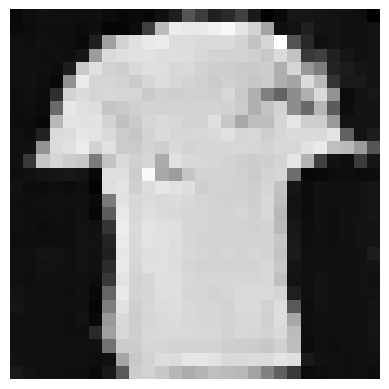

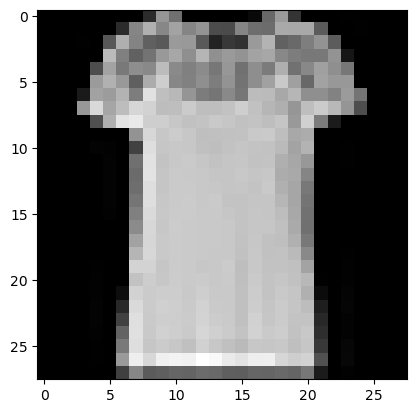

In [23]:
# Visualize the generated samples
if N_SAMPLES > 1: 
    fig, axes = plt.subplots(1, N_SAMPLES, figsize=(15, 5))
    for ax, img in zip(axes, traj):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(-1)  # For grayscale
        ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax.axis('off')
    plt.show()
else: 
    img = traj[0].permute(1, 2, 0).cpu().numpy()
    if img.shape[2] == 1:
        img = img.squeeze(-1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.axis('off')
    plt.show()
# Visualize ground truth samples
visualize_dataset(dataloader, label_show=False)

## Metrics

## FID

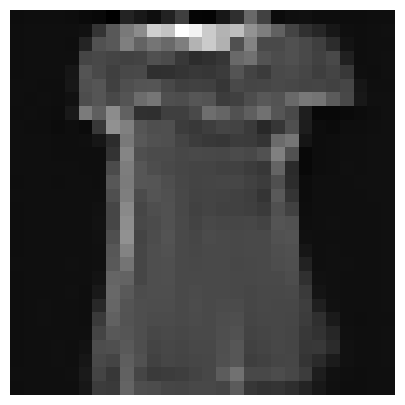

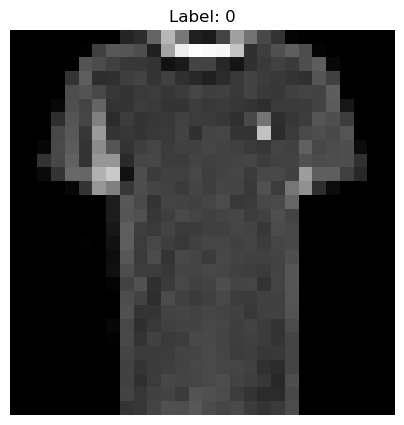

In [25]:
def save_generated_single_label(folder_path, model, label: int, steps: torch.Tensor, n_samples: int, device: str):
    condition = torch.tensor([label] * n_samples, device=device)
    with torch.no_grad():
        traj = torchdiffeq.odeint(
            lambda t, x: model(t, x),
            torch.randn(n_samples, 1, 28, 28, device=device),
            steps,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )
    traj = traj[-1]  # Get the last time step

    label_folder = os.path.join(folder_path, f'{label}')
    os.makedirs(label_folder, exist_ok=True)

    # Save the generated samples
    for idx, img in enumerate(traj):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)
        plt.imsave(os.path.join(label_folder, f'sample_{idx}.png'), img_np, cmap='gray' if img_np.ndim == 2 else None)

    # Visualize the generated samples
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    if n_samples == 1:
        axes = [axes]
    for ax, img in zip(axes, traj):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)
        ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax.axis('off')
    plt.show()

def save_ground_truth_single_label(folder_path, dataloader, label: int, n_samples: int = 1):
    label_folder = os.path.join(folder_path, f'{label}')
    os.makedirs(label_folder, exist_ok=True)
    saved = 0
    for images_batch, labels_batch in dataloader:
        for img, lbl in zip(images_batch, labels_batch):
            if int(lbl.item()) == label:
                img_np = img.permute(1, 2, 0).cpu().numpy()
                if img_np.shape[-1] == 1:
                    img_np = img_np.squeeze(-1)
                plt.imsave(os.path.join(label_folder, f'ground_truth_{saved}.png'), img_np, cmap='gray' if img_np.ndim == 2 else None)
                saved += 1
                if saved >= n_samples:
                    break
        if saved >= n_samples:
            break

    # Visualize the ground truth samples
    fig, axes = plt.subplots(1, saved, figsize=(5 * saved, 5))
    if saved == 1:
        axes = [axes]
    for ax_idx, ax in enumerate(axes):
        img = plt.imread(os.path.join(label_folder, f'ground_truth_{ax_idx}.png'))
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

label = 0
N_SAMPLES = 1
save_generated_single_label('../image/generated_samples', model, label, STEPS, N_SAMPLES, device)
save_ground_truth_single_label('../image/ground_truth_samples', dataloader, label, n_samples=N_SAMPLES)


In [ ]:
from PIL import Image
import glob

import matplotlib.pyplot as plt

fid_scores = {}
label = 0
# Compute FID for current label
print(f"Computing FID for label {label}...")
!python -m pytorch_fid ../image/generated_samples/{label} ../image/ground_truth_samples/{label} --batch-size 1 --device mps > ../image/fid_tmp.txt
with open("../image/fid_tmp.txt") as f:
    for line in f:
        if "FID:" in line:
            fid_scores[label] = float(line.strip().split()[-1])
            print(f"Label {label}: FID = {fid_scores[label]}")

# Visualize 1 image from generated and 1 from ground truth
gen_imgs = sorted(glob.glob(f'../image/generated_samples/{label}/*.png'))
gt_imgs = sorted(glob.glob(f'../image/ground_truth_samples/{label}/*.png'))
fig, axes = plt.subplots(1, 2, figsize=(4, 4))
# Show generated image
if len(gen_imgs) > 0:
    axes[0].imshow(Image.open(gen_imgs[0]), cmap='gray')
    axes[0].set_title(f'Gen {label}')
axes[0].axis('off')
# Show ground truth image
if len(gt_imgs) > 0:
    axes[1].imshow(Image.open(gt_imgs[0]), cmap='gray')
    axes[1].set_title(f'GT {label}')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print("FID scores per label:", fid_scores)

Computing FID for label 0...
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

In [ ]:
# Remove temporary file
import os
if os.path.exists("../image/fid_tmp.txt"):
    os.remove("../image/fid_tmp.txt")

# Remove image folders if needed
import shutil
if os.path.exists('../image/generated_samples'):
    shutil.rmtree('../image/generated_samples')
if os.path.exists('../image/ground_truth_samples'):
    shutil.rmtree('../image/ground_truth_samples')